# Data Preprocessing Pipeline

In [1]:
# standard imports
import os
import random

# 3d-party imports
import h5py
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

# ML
import torch

# local
import utils

# Prepare data
## Load and examine data

In [2]:
with h5py.File('../hypersonic/data/2021-05-08-04-13.h5', 'r') as dset:
    for k, v in dset.attrs.items():
        print(f"{k}: {v}")

class_size: 1000
horizontal_noise: 1.0
radar: 1
radar_coord: [5172967.18425192 3489210.42312431 1317416.0454895 ]
radial_noise: 100
time_step: 1
vertical_noise: 1.0


In [3]:
dset = pd.HDFStore('../hypersonic/data/2021-05-08-04-13.h5', 'r')
print(dset.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../hypersonic/data/2021-05-08-04-13.h5
/ballistic/BALLISTIC_0/measured              frame        (shape->[206,8]) 
/ballistic/BALLISTIC_0/raw                   frame        (shape->[207,8]) 
/ballistic/BALLISTIC_1/measured              frame        (shape->[249,8]) 
/ballistic/BALLISTIC_1/raw                   frame        (shape->[251,8]) 
/ballistic/BALLISTIC_10/measured             frame        (shape->[264,8]) 
/ballistic/BALLISTIC_10/raw                  frame        (shape->[266,8]) 
/ballistic/BALLISTIC_100/measured            frame        (shape->[198,8]) 
/ballistic/BALLISTIC_100/raw                 frame        (shape->[199,8]) 
/ballistic/BALLISTIC_101/measured            frame        (shape->[270,8]) 
/ballistic/BALLISTIC_101/raw                 frame        (shape->[272,8]) 
/ballistic/BALLISTIC_102/measured            frame        (shape->[275,8]) 
/ballistic/BALLISTIC_102/raw                 frame        (shape->[277,8]) 


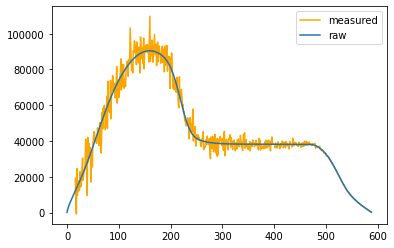

In [4]:
%matplotlib inline
m = dset['/hgv/HGV_0/measured']
plt.plot(m.t, m.alt, c='orange', label='measured')
v = dset['/hgv/HGV_0/raw']
plt.plot(v.t, v.alt, label='raw')
plt.legend()

## Train-Val-Test split keys

In [5]:
def train_val_test_split(data, tts = (0.7, 0.1, 0.2), shuffle=False):
    '''Split data into train, validation and test sets according to `tts` tuple

    By default, tts = (train, val, test) = (0.7, 0.1, 0.2)
    '''
    assert sum(tts) == 1

    if shuffle:
        np.random.shuffle(data)

    h = len(data)
    train = data[:int(h * tts[0])]
    val = data[int(h * tts[0]) : int(h * np.round(tts[0] + tts[1], 4))]
    test = data[int(h * np.round(tts[0] + tts[1], 4)) : int(h * sum(tts))]

    return train, val, test

In [6]:
# Train-val-test split data
data_keys = sorted([key for key in dset.keys() if 'raw' in key])
# Test data       = 20% of total keys
# Validation data = 10% of total keys
# Train data      = 70% of total keys
train_keys, val_keys, test_keys = train_val_test_split(
    data_keys, (0.7, 0.1, 0.2), shuffle=False)

print(f'Train keys: {len(train_keys):>5} -> {len(train_keys)/len(data_keys) * 100}%')
print(f'Valid keys: {len(val_keys):>5} -> {len(val_keys)/len(data_keys) * 100}%')
print(f'Test keys:  {len(test_keys):>5} -> {len(test_keys)/len(data_keys) * 100}%')

Train keys:  2100 -> 70.0%
Valid keys:   300 -> 10.0%
Test keys:    600 -> 20.0%


## Invertible trajectory pre-processing transform

In [7]:
class RelativeTrajectory():
    def __init__(self, df, diff=False, ref_point=30):
    
        self.diff = diff
        self.ref_point = ref_point

        data = np.array(df.drop('t', 1))
        assert data.shape[0] >= ref_point
        
        # Remember first state
        self.start_state = data[0].copy()
        
        # Make changes relative to the start state
        data -= self.start_state

        # Scale data to kilometers
        data /= 1000

        # Rotate coordinate system
        x = utils.normalize(data[-1, :3] - data[0, :3])             # X axis along flight direction
        z = utils.orthogonal(x, data[ref_point, :3] - data[0, :3])  # Z axis along upward (from Earth)
        y = np.cross(z, x)                                          # Y is a cross product to form basis
        
        p = np.array([x, y, z])  # -> Relative CS axes in current frame
        p_prime = np.eye(3)      # -> How they should be
        self.M = utils.get_transformation_matrix(p, p_prime)[:3, :3]
                
        # Perform rotation for coordinates
        data[:, :3] = data[:, :3].dot(self.M)

        # Perform rotation for velocities
        data[:, 3:6] = data[:, 3:6].dot(self.M)

        self.first_diff_elem = None
        if diff:
            self.first_diff_elem = data[0].copy()
            data = np.diff(data, axis=0)

        self.data = data

    def restore(self, columns, ts=1, config=None):

        assert ts > 0

        if config:
            self.set_info(config)

        # Restore diff data
        if self.diff:
            data = np.r_[np.expand_dims(self.first_diff_elem, 0), np.cumsum(self.data, axis=0)]
        else:
            data = self.data.copy()

        # Perform rotation for coordinates
        data[:, 0:3] = data[:, 0:3].dot(np.linalg.inv(self.M))

        # Perform rotation for velocities
        data[:, 3:6] = data[:, 3:6].dot(np.linalg.inv(self.M))

        # Scale data from km back to meters
        data *= 1000
        
        # Make changes absolute
        data += self.start_state

        # Restore Pandas.DataFrame format
        t = np.arange(0, data.shape[0], ts)
        data = np.c_[data, t]
        data = pd.DataFrame(data, columns=columns)

        return data
    
    @property
    def info(self):
        return {
            'ref_point' : self.ref_point,
            'diff' : self.diff,
            'start_state' : self.start_state,
            'first_diff_elem' : self.first_diff_elem,
            'M' : self.M
        }
    
    @info.setter
    def info(self, config):
        self.ref_point = config['ref_point']
        self.diff = config['diff']
        self.start_point = config['start_point']
        self.first_diff_elem = config['first_diff_elem']
        self.M = config['M']

In [8]:
from sklearn.preprocessing import StandardScaler

# Calculate mean and variance over all training set 
print('Calculating mean and variance over all training data...')
scaler = StandardScaler()
means = []
for train_key in tqdm(train_keys):
    traj = RelativeTrajectory(dset[train_key])
    means.append(traj.data.mean(axis=0))

scaler.fit(np.array(means))

Calculating mean and variance over all training data...


  0%|          | 0/2100 [00:00<?, ?it/s]

StandardScaler()

In [9]:
print('Mean:')
pd.DataFrame([scaler.mean_], columns=dset[train_key].columns[:-1])

Mean:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,528.42886,0.267889,57.732402,1.556279,0.001627,-1.984368,41.664201


In [10]:
print('Variance:')
pd.DataFrame([scaler.var_], columns=dset[train_key].columns[:-1])

Variance:


,coord_x,coord_y,coord_z,vel_x,vel_y,vel_z,alt
0,343190.241035,508.876372,52499.777936,1.650817,0.000455,0.002245,657.183471


## Preprocess data for training

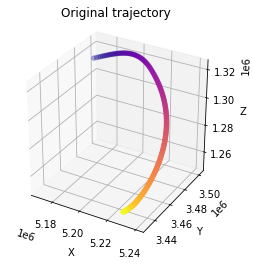

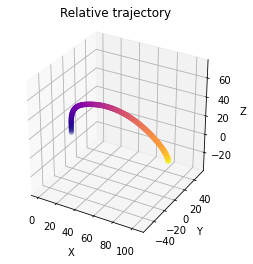

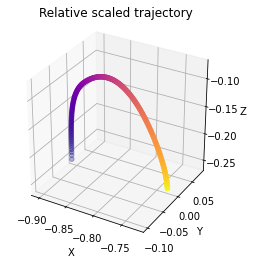

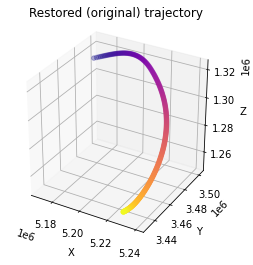

In [11]:
%matplotlib inline
for i in range(1):
    rt = RelativeTrajectory(dset[train_keys[i]], diff=False)
    utils.plot(dset[train_keys[i]], 'Original trajectory')
    utils.plot(rt.data, 'Relative trajectory')
    utils.plot(scaler.transform(rt.data), 'Relative scaled trajectory')
    utils.plot(rt.restore(dset[train_keys[i]].columns), 'Restored (original) trajectory')

In [14]:
def get_strided_data_clust(dset, keys, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, verbose=False):
    '''Return list with parts of trajectories and their residuals.
    
    Arguments:
        dset -- h5py Data set with trajectory data
        keys -- keys for extracting data from `dset`
        
    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude
        
        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]
        
        gt_size -- how many trajectory points are to be observed
        horizon -- how many trajectory points are to be predicted
        step -- (default: 1) 
                if 1, every row from the `dset` will be processed,
                if >1, some rows will be skipped accordingly.
        diff -- (default: False) toggle extract differentiated relative trajectories
    '''
    
    assert variables in [3, 6, 7]
    
    # Create list with parts of trajectories,
    # each element has (gt_size+horizon) trajectory points
    data_seqs = []
    
    # Set of configs for each trajectory. 
    configs = {}
    
    # List of trajectory indices 
    # (to which trajectory this traj_elem belongs to)
    traj_ids = []
    
    # Collect trajectories, preprocess and 
    # split them into trajectory parts
    for k in tqdm(range(len(keys)), disable=1-verbose, desc='Collecting strided data'):
        # Get relative trajectory from the dataset
        rt = RelativeTrajectory(dset[keys[k]], diff=diff)
        configs[k] = rt.info  # save for future restoration

        # Collect list of trajectory parts from `rt` 
        # using time window [gt_size + horizon] and time shift `step`
        for i in range(1 + (rt.data.shape[0] - gt_size - horizon) // step):
            data_seqs.append([rt.data[i*step : i*step + gt_size + horizon, :variables]])
            traj_ids.append(k)
    
    # Collect all data seqs into one huge dataset 
    # of shape [? , gt_size + horizon, variables]
    data_seqs_all = np.stack(data_seqs).squeeze()
    traj_ids_all = np.stack(traj_ids)

    # Calculate mean and std over all data
    data_mean = data_seqs_all.mean((0, 1))
    data_std = data_seqs_all.std((0, 1))
    res_mean = np.zeros(variables)
    res_std = np.ones(variables)
    
    if residuals:
        # Compute and add columns with residuals
        # note that the first row should be zeros
        # (if we have 8 measurements, we only can have 7 residuals)
        res = np.concatenate((
            np.zeros((data_seqs_all.shape[0], 1, variables)),
            data_seqs_all[:, 1:, :] - data_seqs_all[:, :-1, :]
        ), 1)
    
        res_mean = res[:, 1:].mean((0, 1))
        res_std = res[:, 1:].std((0, 1))
    
        data_seqs_all = np.concatenate((data_seqs_all, res), 2)
    
    stats = {
        'data_mean': data_mean,
        'data_std': data_std,
        'res_mean': res_mean,
        'res_std': res_std
    }
    
    if verbose:
        with np.printoptions(precision=3):
            print(f'Total trajectory parts: {data_seqs_all.shape[0]}')
            print(f'Each: {gt_size} observed + {horizon} horizon = {gt_size+horizon} points in total')
            if residuals:
                print(f'Each point contains {int(data_seqs_all.shape[-1]/2)} variables and {int(data_seqs_all.shape[-1]/2)} residuals')
            else:
                print(f'Each point contains {data_seqs_all.shape[-1]} variables')

            print('Data mean:', stats['data_mean'],
                  'Data std:', stats['data_std'], 
                  sep='\n')
            if residuals:
                print('Residuals mean:', stats['res_mean'],
                      'Residuals std:', stats['res_std'], 
                      sep='\n')
    return (
        data_seqs_all.squeeze()[:, :gt_size], # src sequences
        data_seqs_all.squeeze()[:, gt_size:], # tgt sequences
        configs,
        stats,
        traj_ids_all
    )

In [15]:
inp, out, configs, stats, traj_ids = get_strided_data_clust(
    dset,
    train_keys,
    gt_size=8,
    horizon=12,
    step=1,
    variables=7,
    residuals=True,
    diff=False,
    verbose=True
)

Total trajectory parts: 1037162
Each: 8 observed + 12 horizon = 20 points in total
Each point contains 7 variables and 7 residuals
Data mean:
[ 8.029e+02 -3.361e+00  2.254e+01  2.114e+00  1.492e-03 -1.985e+00
  4.387e+01]
Data std:
[1.045e+03 1.403e+02 8.176e+02 1.853e+00 1.838e-01 8.225e-01 3.367e+01]
Residuals mean:
[ 1.892e+00  3.246e-05 -1.106e-02  2.625e-04 -1.902e-06 -2.567e-03
 -1.046e-02]
Residuals std:
[1.720e+00 1.813e-01 8.164e-01 2.672e-02 1.525e-03 1.158e-02 3.941e-01]


In [16]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, data, name, variables=3, configs=None, stats=None):
        super().__init__()
    
        self.data = data
        self.name = name
        self.variables = variables
        self.configs = configs
        self.stats = stats
        
    def __len__(self):
        return self.data['src'].shape[0]
    
    def __getitem__(self, index):
        
        ret =  {
            'src': torch.Tensor(self.data['src'][index]),
            'tgt': torch.Tensor(self.data['tgt'][index]),
            'traj_id': self.data['traj_ids'][index],
        }
        return ret

In [17]:
def create_dataset(dset, keys, name, variables=3, residuals=True, gt_size=8, horizon=12, step=1, diff=False, train=True, scaler=None, verbose=False):
    """Create TrajectoryDataset for training NNs.

    Arguments:
        dset -- h5py dataset object
        keys -- list of strings: keys for extracting data from `dset`
        name -- name of the TrajectoryDataset

    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude

        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]

        gt_size -- how many points are observed (model input)
        horizon -- how many points the model tries to predict into the future
        step -- stride step for data
        diff -- toggle differentiate trajectories
        train -- this data will be used for training
        scaler -- custom scaler, so data will have zero mean and unit variance
        verbose -- toggle print info to the terminal
        
    Note:
        If `train == True`, the scaler will fit on the collected data and
        then returned as the TrajectoryDataset.scaler attribute
        
        If 'train == False', this function will look for scaler from the 
        arguments, then use it to scale collected data for evaluation.
    """
    if verbose:
        print(f"Loading dataset in {'train' if train else 'evaluation'} mode...")

    inp, out, configs, stats, traj_ids = get_strided_data_clust(
        dset, keys, variables, residuals, gt_size, horizon, step, diff, verbose)

    data = {
        'src': inp,
        'tgt': out, 
        'traj_ids': traj_ids
    }

    return TrajectoryDataset(data, name, variables, configs, stats)

In [18]:
td = create_dataset(
    dset,
    train_keys[:10],
    name='train',
    variables=3,
    residuals=True,
    gt_size=8,
    horizon=12,
    train=True,
    verbose=True
)

Loading dataset in train mode...


Total trajectory parts: 2333
Each: 8 observed + 12 horizon = 20 points in total
Each point contains 3 variables and 3 residuals
Data mean:
[74.795  0.08  47.797]
Data std:
[56.063  0.087 26.439]
Residuals mean:
[ 6.673e-01  4.778e-05 -2.931e-02]
Residuals std:
[0.257 0.002 0.597]


In [19]:
train_dl = torch.utils.data.DataLoader(
    td,
    batch_size=2,
    shuffle=False,
    num_workers=0)

In [20]:
for id_b, batch in enumerate(train_dl):
    
    print(batch)
    break

{'src': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-1.2600e-02,  2.4371e-04,  1.7171e+00, -1.2600e-02,  2.4371e-04,
           1.7171e+00],
         [-2.1859e-02,  4.2762e-04,  3.0725e+00, -9.2590e-03,  1.8391e-04,
           1.3554e+00],
         [-2.8624e-02,  5.7281e-04,  4.2218e+00, -6.7648e-03,  1.4518e-04,
           1.1493e+00],
         [-3.3113e-02,  6.8881e-04,  5.2396e+00, -4.4893e-03,  1.1601e-04,
           1.0178e+00],
         [-3.5280e-02,  7.8075e-04,  6.1668e+00, -2.1668e-03,  9.1941e-05,
           9.2724e-01],
         [-3.4943e-02,  8.5179e-04,  7.0282e+00,  3.3630e-04,  7.1036e-05,
           8.6141e-01],
         [-3.1847e-02,  9.0413e-04,  7.8398e+00,  3.0967e-03,  5.2340e-05,
           8.1161e-01]],

        [[-1.2600e-02,  2.4371e-04,  1.7171e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-2.1859e-02,  4.2762e-04,  3.0725e+00, -9.2590e-03,  1.8391e-04,
           1.3554e+00],


In [21]:
td.stats

{'data_mean': array([74.79524206,  0.07986858, 47.79723038]),
 'data_std': array([56.06272115,  0.08745655, 26.43877867]),
 'res_mean': array([ 6.67275706e-01,  4.77760649e-05, -2.93142006e-02]),
 'res_std': array([0.25661136, 0.00188313, 0.59744303])}